In [1]:
import tensorflow as tf
import numpy as np
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

# TensorFlow Feed-Forward Neural Network

This notebook walks through how to build a feed-forward neural network using TensorFlow. Nearly everything is the same as the NumPy implementation, except a static graph is constructed using TensorFlow. To see the process in more detail (without level-by-level encapsulation), take a look at the TensorFlow Feed-Forward Neural Network Detailed notebook.

## Layers

Instead of unrolling the network as shown in the detailed notebook, we encapsulate the common, repeated behavior into layer classes.

### Base Layer

This layer provides the virtual methods that each layer has to implement. If the layer doesn't implement the method, we default to one of these empty methods.

In [2]:
class Layer:
    """Abstract base layer for our neural network."""

The `__init__` method sets up constant information about the layer that is necessary to build the graph later. Typically, only dimensions of input/output data is required.

In [3]:
    def __init__(self):
        """Initializes layer constants necessary to construct the graph
            for training. Likely: just dimension information or nothing
            at all."""
        
Layer.__init__ = __init__

Once the information about the layer is obtained from `__init__`, we can construct any variables in the graph needed by the layer using the `build` method. In the NumPy version, this is accomplished within `__init__`. We split this operation into two because at the time of initialization, we do not have a graph defined. Without a graph, we cannot create variables.

In [4]:
    def build(self):
        """Adds any variables to the graph required by the layer. (Such
            as weight matrices.)"""
        
Layer.build = build

Each of the layers need to be connected to each other for the forward pass. This is accomplished through the `build_forward` method. Note that this is not the same as a `forward` method in the NumPy version as nothing is being computed yet. In the `build_forward` method, we are constructing operations within the graph to be executed at a later time.

In [5]:
    def build_forward(self, X):
        """Connects the layer to the previous layer through a new 
            operation in the forward pass process.
            
        Args:
            X (Tensor): A tensor representing the inputs to the layer.
                Likely: A or Z depending on the layer.
        
        Returns:
            Tensor: A tensor representing the outputs of the layer. Likely:
                Z or A depending on the layer.
                
        """

Layer.build_forward = build_forward

The layers also need to be connected to form the backward pass. We do this using the `build_backward` method. Again, this is not the same as the `backward` method as nothing is executed, only the operation is defined.

In [6]:
    def build_backward(self, dL):
        """Connects the layer to the next layer through a new operation
            in the backward pass process.
            
        Args:
            dL (Tensor): A tensor representing the gradient of the loss
                of the network with respect to the outputs of the current
                layer. Likely: dLdA or dLdZ depending on the layer.
        
        Returns:
            Tensor: A tensor representing the gradient of the loss of the
                network will respect to the inputs of the current layer.
                Likely: dLdZ or dLdA depending on the layer.
        
        """

Layer.build_backward = build_backward

Some layers need to update variables when they go through the training process. These variables are updated in the `build_sgd_step` method.

In [7]:
    def build_sgd_step(self, eta):
        """Updates trainable variables based off the results from the
            backward pass.
            
        Args:
            eta (float): The learning rate to use for the stochastic
                gradient descent update step.
        
        """

Layer.build_sgd_step = build_sgd_step

### Linear Layer

This is the simplest possible layer where all inputs are connected to all outputs.

In [8]:
class Linear(Layer):
    """Simple layer fully-connecting inputs to outputs linearly."""

To initialize this network, we just need to know the input dimensions and the output dimensions.

In [9]:
    def __init__(self, m, n):
        """Initializes the dimensions of the layer.
        
        Args:
            m (int): Number of input features to the layer.
            n (int): Number of output features of the layer.
        
        """
        self.m = m
        self.n = n
        
Linear.__init__ = __init__

With the dimensions known, we can construct the variables on the graph. Here are a few notes to consider:

- We add new variables to our graph using the `get_variable`. This the standard preferred method to introduce trainable parameters.
- Since we will likely have many of these `Linear` layers, we need to scope our variables as duplicate variable names are not allowed. By using `default_name`, TensorFlow will ensure our variable scopes are unique.
- The variables need to be initialized to some values when the graph is constructed. To tell TensorFlow what these should be initialized to later, we use `zeros_initializer` for $W_0$ and `random_normal_initializer` for $W$.
- This method assumes that the graph we wish to add the variables to is the default graph. This is only important to consider when training multiple different graphs at one time.

In [10]:
    def build(self):
        """Creates the trainable variables on the default graph for 
            the Linear layer."""
        with tf.variable_scope(name_or_scope=None, default_name='Linear'):
            
            self.W = tf.get_variable(name='W', shape=(self.m, self.n), initializer=tf.random_normal_initializer(0.0, tf.sqrt(1 / self.m)))
            self.W0 = tf.get_variable(name='W0', shape=(self.n, 1), initializer=tf.zeros_initializer)

Linear.build = build

With our variables defined, we can build the forward pass. We take the activation $A$ from the previous layer and produce the current $Z$ pre-activation.

In [11]:
    def build_forward(self, A):
        """Connects the linear layer to the previous layer by operating
            on the previous activation.
            
        Args:
            A (Tensor): An m by b tensor representing the activations from
                the previous layer with a batch of size b.
                
        Returns:
            Tensor: An n by b tensor, Z, representing the pre-activations
                as the output from this linear layer.
        
        """
        # We need this input later when computing the backward path.
        self.A = A
        
        return tf.transpose(self.W) @ self.A + self.W0
    
Linear.build_forward = build_forward

For now, we will compute the gradients by hand using back-propogation. We take the gradient of the loss with respect to the pre-activations of the layer $\partial \mathrm{Loss} / \partial Z$ and compute the gradient of the loss with respect to the activations of the previous layer $\partial \mathrm{Loss} / \partial A$. 

In addition, we save gradients of the loss with respect to the weights ($\partial \mathrm{Loss} / \partial W$ and $\partial \mathrm{Loss} / \partial W_0$) for the stochastic gradient descent update step.

In [12]:
    def build_backward(self, dLdZ):
        """Connects the next layer to the current layer using backward 
            process. Also records gradients of the loss with respect to
            weights for later stochastic gradient descent updates.
        
        Args:
            dLdZ (Tensor): An n by b tensor representing the gradient of
                the loss with respect to the current layer's 
                pre-activations for a batch of size b.
                
        Returns:
            Tensor: An m by b tensor, dLdA, representing the gradient of 
                the loss with respect to the previous layer's activations.
        
        """
        # We store these gradients for use later in the sgd_step
        self.dLdW = self.A @ tf.transpose(dLdZ)
        self.dLdW0 = tf.reduce_sum(dLdZ, axis=1, keepdims=True)

        return self.W @ dLdZ
    
Linear.build_backward = build_backward

The linear layer has some trainable parameters to update. Using the specified learning rate $\eta$, we can re-assign our variable values using stochastic gradient descent. Note that these are not executed when this method is called!Since these are isolated operations, we need to return handles to them to be executed later. To execute in parallel, we use `tf.group`.

In [13]:
    def build_sgd_step(self, eta):
        """Constructs the training update operations for the Linear layer
            weight parameters.
            
        Args:
            eta (float): The learning rate to use for the stochastic
                gradient descent update step.
        
        Returns:
            Operation: An operation that executes the stochastic gradient
                descent step for all weights.
        
        """
        return tf.group(self.W.assign_sub(eta * self.dLdW),
                        self.W0.assign_sub(eta * self.dLdW0))

Linear.build_sgd_step = build_sgd_step

### Rectified Linear Unit Activation Layer

This layer applies the relu activation function to each of the inputs element-wise.

In [14]:
class ReLU(Layer):
    """Applies relu activation function to all inputs."""

We have no variables to consider, we just need to construct the forward and backward passes. With the forward pass we compute the activation $A$ using the previous layer's pre-activation $A$.

In [15]:
    def build_forward(self, Z):
        """Connects the previous later to the current layer using the
            ReLU operation forward pass.
            
        Args:
            Z (Tensor): An m by b tensor representing the pre-activations
                from the previous layer for a batch of size b.
        
        Returns:
            Tensor: An n by b tensor, A, representing the activations from
                the current layer for a batch of size b. (Note: n and m 
                are equal.)
                
        """
        # We need this activation when computing the backward step later
        self.A = tf.maximum(0.0, Z)
        
        return self.A
    
ReLU.build_forward = build_forward

In the backward pass, we use the gradient of the loss with respect to the layer's activations $\partial \mathrm{Loss} / \partial A$ to compute the gradient of the loss with respect to the previous layer's pre-activations $\partial \mathrm{Loss} / \partial Z$.

In [16]:
    def build_backward(self, dLdA):
        """Connects the current layer to the next using the backward pass 
            process.
            
        Args:
            dLdA (Tensor): An n by b tensor representing the gradient of
                the loss with respect to the current layer's activations
                for a batch of size b.
        
        Returns:
            Tensor: An m by b tensor, dLdZ, representing the gradient of
                the loss with respect to the previous layer's activations
                for a batch of size b. (Note: n and m are equal.)
        
        """
        return tf.sign(self.A) * dLdA
    
ReLU.build_backward = build_backward

### Hyperbolic Tangent Activation Layer

This layer applies the hyperbolic tangent activation function to each input element-wise.

In [17]:
class Tanh(Layer):
    """Applies hyperbolic tangent activation function to all inputs."""

There are no variables in this layer, thus we only need to worry about forward and backward passes. The forward pass takes the previous layer's pre-activation $Z$ and produces the activation $A$.

In [18]:
    def build_forward(self, Z):
        """Connects the previous layer to the current layer using the
            backward pass process.
        
        Args:
            Z (Tensor): An m by b tensor representing the previous layer's
                pre-activation for a batch of size b.
        
        Returns:
            Tensor: An n by b tensor, A, representing the layer's 
                activation for a batch of size b. (Note: m and n are
                equal.)
                
        """
        # We need this activation when computing the backward step later
        self.A = tf.tanh(Z)
        
        return self.A
    
Tanh.build_forward = build_forward

The backward pass uses the gradient of the loss with respect to the layer's activation $\partial \mathrm{Loss} / \partial A$ to compute the gradient of the loss with respect to the previous layer's pre-activation $\partial \mathrm{Loss} / \partial Z$.

In [19]:
    def build_backward(self, dLdA):
        """Connects the next layer to the current layer using the
            backward pass process.
            
        Args:
            dLdA (Tensor): An n by b tensor representing the gradient of
                the loss with respect to this layer's activation for a 
                batch of size b.
                
        Returns:
            Tensor: An m by b tensor, dLdZ, representing the gradient of 
                the loss with respect to the previous layer's 
                pre-activation for a batch of size b. (Note: n and m are 
                equal.)
                
        """
        return (1.0 - self.A ** 2.0) * dLdA

Tanh.build_backward = build_backward

### Softmax Activation Layer

This layer applies the softmax activation function to the inputs.

In [20]:
class Softmax(Layer):
    """Applies the softmax activation function to layer inputs."""

As with the other activation layers, there are no variables to consider. The forward pass takes the previous layer's pre-activations $Z$ and computes the current layer's activation $A$.

In [21]:
    def build_forward(self, Z):
        """Connects the previous layer to the current layer using the
            forward pass process.
            
        Args:
            Z (Tensor): An m by b tensor representing the previous layer's
                pre-activation for a batch of size b.
        
        Returns:
            Tensor: An n by b tensor, A, representing the current layer's
                activation for a batch of size b. (Note: m and n are
                equal.)
                
        """
        # We need this activation when computing the backward step later
        self.A = tf.exp(Z) / tf.reduce_sum(tf.exp(Z), axis=0, keepdims=True)
        
        return self.A
    
Softmax.build_forward = build_forward

In the backward pass, we use the gradient of the loss with respect to the current layer's activations $\partial \mathrm{Loss} / \partial A$ to compute the gradient of the loss with respect to the previous layer's pre-activations $\partial \mathrm{Loss} / \partial Z$.

In [22]:
    def build_backward(self, dLdA):
        """Connects the next layer to the current layer using the
            backward pass process.
            
        Args:
            dLdA (Tensor): An n by b tensor representing the gradient of
                the loss with respect to the current layer's activation.
                
        Returns:
            Tensor: An m by b tensor, dLdZ, representing the gradient of 
                the loss with respect to the previous layer's 
                pre-activation. (Note: n and m are equal.)
            
        """
        n = dLdA.shape[0].value
        
        # This is just a way to compute dLdZ by using the provided dLdA
        # and softmax's dAdZ tensor. Or you can assume dLdZ is passed in.
        return tf.einsum('ikj,kj->ij', tf.einsum('jk,jk,ji->ijk', self.A, 1.0 - self.A, tf.eye(n)) + tf.einsum('jk,ik,ji->ijk', -self.A, self.A, 1.0 - tf.eye(n)), dLdA)
    
Softmax.build_backward = build_backward

### Negative Log-Likelihood Multi-Class Loss Layer

This layer computes the loss of the output of the network compared with the expected results.

In [23]:
class NLLM(Layer):
    """Computes the negative log-likelihood multi-class loss for neural
        network outputs and expected outputs."""

Like the activation layers, there are no variables to consider. The forward pass takes the neural network's final activations $A$ and the expected outputs
$Y$ and computes the loss scalar.

In [24]:
    def build_forward(self, A, Y):
        """Connects the neural network to the loss layer using the forward 
            pass process.
            
        Args:
            A (Tensor): An n by b tensor representing the neural network's
                outputs for a batch of size b.
            Y (Tensor): An n by b tensor representing the expected outputs
                from the neural network for a batch of size b.
        
        Returns:
            float: A scalar, L, which represents the loss of the neural
                network for a batch of size b.
        
        """
        # We will need both of these later to compute the backward pass.
        self.A = A
        self.Y = Y

        return -tf.reduce_sum(self.Y * tf.log(self.A))
    
NLLM.build_forward = build_forward

The backward pass computes the gradient of the loss with respect to the neural network's final activations $\partial \mathrm{Loss} / \partial A$. Note, this is not immediately computing $\partial \mathrm{Loss} / \partial Z$ by assuming softmax activations.

In [25]:
    def build_backward(self):
        """Starts off the whole backward pass process.
        
        Returns:
            Tensor: An n by b tensor, dLdA, representing the gradient of
                the loss with respect to the neural network's outputs.
                
        """
        return -self.Y / self.A

NLLM.build_backward = build_backward

### Accuracy Layer

Unlike the NumPy implementation, we need to explicitly provide a layer that computes the accuracy (quite similar to the loss layer above). Any value we wish to compute from the neural network must be implemented in the graph.

In [26]:
class Accuracy(Layer):
    """Computes the accuracy of the current neural network outputs and
        expected outputs."""

We only care about the forward pass as nothing uses the gradient of the accuracy. The forward pass uses the network's current outputs $A$ and the expected outputs $Y$ to compute the accuracy.

In [27]:
    def build_forward(self, A, Y):
        """Connects the neural network to the accuracy layer using the forward
            pass process.
            
        Args:
            A (Tensor): An n by b tensor representing the neural network's
                outputs for a batch of size b.
            Y (Tensor): An n by b tensor representing the expected outputs
                from the neural network for a batch of size b.
        
        Returns:
            float: A scalar, acc, which represents the accuracy of the neural
                network for a batch of size b.
        
        """        
        return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(A, axis=0), tf.argmax(Y, axis=0)), tf.float32))
    
Accuracy.build_forward = build_forward

## Model

Now we have all the components to construct our neural network, but we need a model to connect them together.

### Sequential Model

The sequential model simply connects all the layer linearly.

In [28]:
class Sequential:
    """A standard neural network model with linearly stacked layers."""

The first step to construct the model is to provide a list of layers. This is a little different from the NumPy implementation. From this list of layers, a graph is initialized for the model construction, and a graph session is initialized for training the model.

In [29]:
    def __init__(self, layers):
        """Initializes the model by saving the layers provided. Note the
            model is not ready for training yet. Please call the build
            method.
            
        Args:
            layers (list of Layer): A list of layers in sequential order
                to construct the model from.
        
        """
        self.layers = layers
        
        # When we build layer, we need to know input and output dimensions.
        self.m = self.layers[0].m
        self.n = self.layers[0].n
        for layer in self.layers[1:]:
            self.n = getattr(layer, 'n', self.n)
        
        # This is the static graph representing our model
        self.graph = tf.Graph()
        
        # This is the runtime instance of our model
        self.sess = tf.Session(graph=self.graph)

Sequential.__init__ = __init__

Before we can train, we need to construct the entire model graph from the provided layers. This is accomplished through a build method (similar to the compile method used in `tf.keras`).

In [30]:
    def build(self, eta, loss, metrics):
        """Constructs the model's graph from the provided layers with the
            specified loss and metrics.
            
        Args:
            eta (float): A scalar representing the learning rate for
                stochastic gradient descent.
            loss (Layer): A layer used to construct the objective for
                stochastic gradient descent.
            metrics (list of Layers): A list of layers to use when
                evaluating model performance.
                
        """
        # This ensures that the graph we add our variables to the graph
        # unique to the model.
        with self.graph.as_default():
        
            self.X = tf.placeholder(name='X', shape=(self.m, None), dtype=tf.float32)
            self.Y = tf.placeholder(name='Y', shape=(self.n, None), dtype=tf.float32)

            for layer in self.layers + [loss] + metrics:
                layer.build()

            self.forward = self.build_forward(self.X)
            self.loss_forward = loss.build_forward(self.forward, self.Y)
            self.metrics_forward = tf.tuple([metric.build_forward(self.forward, self.Y) for metric in metrics])

            loss_backward = loss.build_backward()
            self.build_backward(loss_backward)

            self.build_sgd_step(eta)
            
            initializer = tf.global_variables_initializer()
        
        # This initializes the variables in our graph using the current 
        # instance session
        self.sess.run(initializer)
        
Sequential.build = build

There are various helper methods called by the build method similar to those used in training in the NumPy implementation. The first is `build_forward`. This method constructs the entire forward pass and saves a handle to the operation in `self.forward`. Note that this does not return a value!

In [31]:
    def build_forward(self, X):
        """Constructs the entire forward pass for the network by 
            connecting each layer together.
        
        Args:
            X (Tensor): An m by b tensor representing the placeholder 
                inputs to the neural network for a batch of size b.
                
        Returns:
            Tensor: An n by b tensor representing the final output of the 
                neural network for a batch of size b to be evaluated in a 
                graph session.
                
        """        
        self.forward = X
        for layer in self.layers:
            self.forward = layer.build_forward(self.forward)
        
        return self.forward

Sequential.build_forward = build_forward

The `build_backward` method constructs the entire backward pass of the network to compute the gradients for the training step later on.

In [32]:
    def build_backward(self, dL):
        """Constructs the neural network's backward pass by connecting 
            each layer together.
            
        Args:
            dL (Tensor): An n by b tensor representing the gradient of the
                loss with respect to the output of the neural network.
                
        """        
        for layer in self.layers[::-1]:
            dL = layer.build_backward(dL)
    
Sequential.build_backward = build_backward

To train the model, we need to construct an operation that updates all the weights within the model. This is accomplished by the `build_sgd_step` method which iterates all `sgd_step` methods in the layers and groups together the ones which have weights to update. When `self.sgd_step` is called later, these updates will take place in parallel.

In [33]:
    def build_sgd_step(self, eta):
        """Constructs the stochastic gradient descent training update step 
            for the entire neural network.
            
        Args:
            eta (float): A learning rate for stochastic gradient descent.
            
        Returns:
            Operation: An operation that executes each layer's stochastic
                gradient descent update step in parallel.
                
        """        
        sgd_steps = [layer.build_sgd_step(eta) for layer in self.layers]
        self.sgd_step = tf.group(*[sgd_step for sgd_step in sgd_steps if sgd_step is not None])
        
        return self.sgd_step
    
Sequential.build_sgd_step = build_sgd_step

Now our entire graph is constructed. To train the model, we use the `sgd` method. In this method, since the logic is saved in the graph from the `build` method, we just need to execute the training operation.

In [34]:
    def sgd(self, X_train, Y_train, epochs=100):
        """Performs stochastic gradient descent on the model.
        
        Args:
            X_train (ndarray): A d by n NumPy array representing n input
                training points each with d features.
            Y_train (ndarray): A c by n NumPy array representing n output
                training points each with c features.
            epochs (int): Number of iterations to run stochastic gradient
                descent.
                
        """
        _, n = X_train.shape
        
        for epoch in range(epochs):

            t = np.random.randint(n)
            
            Xt = X_train[:, t:t + 1]
            Yt = Y_train[:, t:t + 1]

            self.sess.run(self.sgd_step, feed_dict={ self.X: Xt, self.Y: Yt })
            
            if epoch % 250 == 1:
                
                metrics_eval = self.sess.run(self.metrics_forward, feed_dict={ self.X: X_train, self.Y: Y_train })
                print('Iteration =', epoch, '\tAcc =', metrics_eval[1], '\tLoss =', metrics_eval[0], flush=True)

Sequential.sgd = sgd

Unlike the NumPy implementation where the `forward` method could be used for prediction, the TensorFlow implementation needs the execution to take place within a graph session. So, we wrap the forward result in a prediction method.

In [35]:
    def predict(self, X):
        """Returns the output from the forward pass.
        
        Args:
            X (ndarray): A d by n NumPy array representing n points each
                with d features to predict outputs.
                
        Returns:
            ndarray: A c by n NumPy array representing the outputs from
                n points each with c features.
                
        """
        return self.sess.run(self.forward, feed_dict={ self.X: X })
    
Sequential.predict = predict

## Training

Our model is complete! Let's train it on some data and see how will it can classify. We will use the standard 'hard' data set used previously.

In [36]:
X = np.array([[-0.23390341,  1.18151883, -2.46493986,  1.55322202,  1.27621763,
                2.39710997, -1.34403040, -0.46903436, -0.64673502, -1.44029872,
               -1.37537243,  1.05994811, -0.93311512,  1.02735575, -0.84138778,
               -2.22585412, -0.42591102,  1.03561105,  0.91125595, -2.26550369],
              [-0.92254932, -1.10309630, -2.41956036, -1.15509002, -1.04805327,
                0.08717325,  0.81847250, -0.75171045,  0.60664705,  0.80410947,
               -0.11600488,  1.03747218, -0.67210575,  0.99944446, -0.65559838,
               -0.40744784, -0.58367642,  1.05972780, -0.95991874, -1.41720255]])

Y = np.array([[0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.],
              [1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0.]])

Let's start by taking a look at our data.

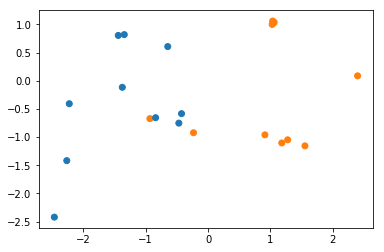

In [37]:
_ = plt.scatter(X[0,:], X[1,:], c=Y[1,:], cmap=ListedColormap(['#1f77b4', '#ff7f0e']))

Now we can construct a neural network we think might be able to classify these points.

In [38]:
model = Sequential([Linear(2, 10), ReLU(),
                    Linear(10, 10), ReLU(),
                    Linear(10, 2), Softmax()])

Don't forget that we need to build the model before we use it!

In [39]:
model.build(0.005, NLLM(), [NLLM(), Accuracy()])

Instructions for updating:
Colocations handled automatically by placer.


Let's try training the model on the data for a few thousand iterations.

In [40]:
model.sgd(X, Y, 100000)

Iteration = 1 	Acc = 0.35 	Loss = 14.2715645
Iteration = 251 	Acc = 0.9 	Loss = 8.61764
Iteration = 501 	Acc = 0.9 	Loss = 6.8519754
Iteration = 751 	Acc = 0.9 	Loss = 5.8082747
Iteration = 1001 	Acc = 0.9 	Loss = 5.1170826
Iteration = 1251 	Acc = 0.95 	Loss = 4.5887856
Iteration = 1501 	Acc = 0.95 	Loss = 4.2604237
Iteration = 1751 	Acc = 0.95 	Loss = 4.078884
Iteration = 2001 	Acc = 0.95 	Loss = 3.8907197
Iteration = 2251 	Acc = 0.95 	Loss = 3.778599
Iteration = 2501 	Acc = 0.95 	Loss = 3.7373128
Iteration = 2751 	Acc = 0.95 	Loss = 3.6215448
Iteration = 3001 	Acc = 0.95 	Loss = 3.5726953
Iteration = 3251 	Acc = 0.95 	Loss = 3.5334105
Iteration = 3501 	Acc = 0.95 	Loss = 3.495299
Iteration = 3751 	Acc = 0.95 	Loss = 3.4614756
Iteration = 4001 	Acc = 0.95 	Loss = 3.4282522
Iteration = 4251 	Acc = 0.95 	Loss = 3.4275966
Iteration = 4501 	Acc = 0.95 	Loss = 3.5106797
Iteration = 4751 	Acc = 0.95 	Loss = 3.400843
Iteration = 5001 	Acc = 0.95 	Loss = 3.3402743
Iteration = 5251 	Acc = 0.95

Iteration = 43251 	Acc = 0.95 	Loss = 1.2000728
Iteration = 43501 	Acc = 0.95 	Loss = 1.2121378
Iteration = 43751 	Acc = 1.0 	Loss = 1.1569403
Iteration = 44001 	Acc = 1.0 	Loss = 1.2106066
Iteration = 44251 	Acc = 1.0 	Loss = 1.1169077
Iteration = 44501 	Acc = 1.0 	Loss = 1.1769404
Iteration = 44751 	Acc = 1.0 	Loss = 1.2065994
Iteration = 45001 	Acc = 1.0 	Loss = 1.0976676
Iteration = 45251 	Acc = 1.0 	Loss = 1.0900944
Iteration = 45501 	Acc = 1.0 	Loss = 1.0873358
Iteration = 45751 	Acc = 0.95 	Loss = 1.2334521
Iteration = 46001 	Acc = 1.0 	Loss = 1.0917445
Iteration = 46251 	Acc = 1.0 	Loss = 1.0666668
Iteration = 46501 	Acc = 1.0 	Loss = 1.0613105
Iteration = 46751 	Acc = 1.0 	Loss = 1.0819135
Iteration = 47001 	Acc = 0.95 	Loss = 1.1822215
Iteration = 47251 	Acc = 1.0 	Loss = 1.0758762
Iteration = 47501 	Acc = 0.95 	Loss = 1.2043309
Iteration = 47751 	Acc = 1.0 	Loss = 1.0780275
Iteration = 48001 	Acc = 1.0 	Loss = 1.0587723
Iteration = 48251 	Acc = 1.0 	Loss = 1.0636532
Iteratio

Iteration = 86501 	Acc = 1.0 	Loss = 0.23371807
Iteration = 86751 	Acc = 1.0 	Loss = 0.26825958
Iteration = 87001 	Acc = 1.0 	Loss = 0.22967516
Iteration = 87251 	Acc = 1.0 	Loss = 0.28164747
Iteration = 87501 	Acc = 1.0 	Loss = 0.22692965
Iteration = 87751 	Acc = 1.0 	Loss = 0.2221748
Iteration = 88001 	Acc = 1.0 	Loss = 0.23148341
Iteration = 88251 	Acc = 1.0 	Loss = 0.23315668
Iteration = 88501 	Acc = 1.0 	Loss = 0.22188465
Iteration = 88751 	Acc = 1.0 	Loss = 0.2116588
Iteration = 89001 	Acc = 1.0 	Loss = 0.24214983
Iteration = 89251 	Acc = 1.0 	Loss = 0.21318258
Iteration = 89501 	Acc = 1.0 	Loss = 0.2612665
Iteration = 89751 	Acc = 1.0 	Loss = 0.2203569
Iteration = 90001 	Acc = 1.0 	Loss = 0.20966323
Iteration = 90251 	Acc = 1.0 	Loss = 0.20505546
Iteration = 90501 	Acc = 1.0 	Loss = 0.21601273
Iteration = 90751 	Acc = 1.0 	Loss = 0.21490137
Iteration = 91001 	Acc = 1.0 	Loss = 0.20764935
Iteration = 91251 	Acc = 1.0 	Loss = 0.2155894
Iteration = 91501 	Acc = 1.0 	Loss = 0.193656

Seems like it has fitted the data 100\%. Let's see what the decision boundary looks like.

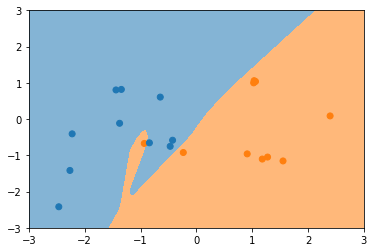

In [41]:
# Create a grid of points to classify
xx1, xx2 = np.meshgrid(np.arange(-3, 3, 0.005), np.arange(-3, 3, 0.005))

# Flatten the grid to pass into model
grid = np.c_[xx1.ravel(), xx2.ravel()].T

# Predict classification at every point on the grid
Z = model.predict(grid)[1, :].reshape(xx1.shape)

# Plot the prediction regions.
plt.imshow(Z, interpolation='bicubic', origin='lower', extent=[-3, 3, -3, 3], 
           cmap=ListedColormap(['#1f77b4', '#ff7f0e']), alpha=0.55, aspect='auto')

# Plot the original points.
_ = plt.scatter(X[0,:], X[1,:], c=Y[1,:], cmap=ListedColormap(['#1f77b4', '#ff7f0e']))